In [1]:
# scientific libraries
import numpy as np
import matplotlib.pyplot as plt
from scipy  import signal

# general libraries
import os  
import json
import time
import h5py as h5py
import copy

# jupyter imports
import ipywidgets as widgets
from IPython.display import clear_output

# local libraries
from analysis import *
from general_utils import *
from hdf_utils import unpack_hdf, Workspace
from scalebars import *
import deconv

In [2]:
# %matplotlib notebook
# %matplotlib widget
%matplotlib ipympl
# %matplotlib qt
plt.rcParams.update({"figure.max_open_warning": 0})
plt.rcParams['svg.fonttype'] = 'none'  # don't save font as paths (assumes font present on machine)
plt.rcParams["font.sans-serif"] = ["Arial", "Helvetica", "Roboto"]

In [3]:
fig_path = "/mnt/Data/NEURONoutput/sac_net/oscillating_clamp/"
os.makedirs(fig_path, exist_ok=True)
exts = [".png", ".svg"]

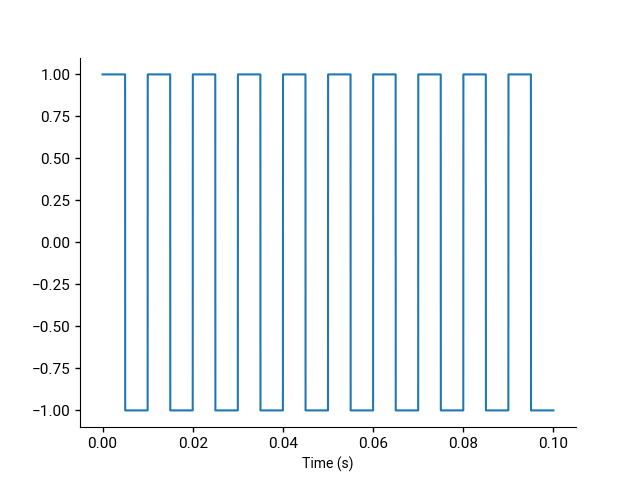

In [4]:
n_pts = 100000
dur = 0.1
hz = 100

xaxis = np.linspace(0, dur, n_pts, endpoint=False)
sq = signal.square(2 * np.pi * hz * xaxis)
square_fig, square_ax = plt.subplots(1)
square_ax.plot(xaxis, sq)
square_ax.set_xlabel("Time (s)")
square_ax.set_ylabel("")
clean_axes(square_ax)

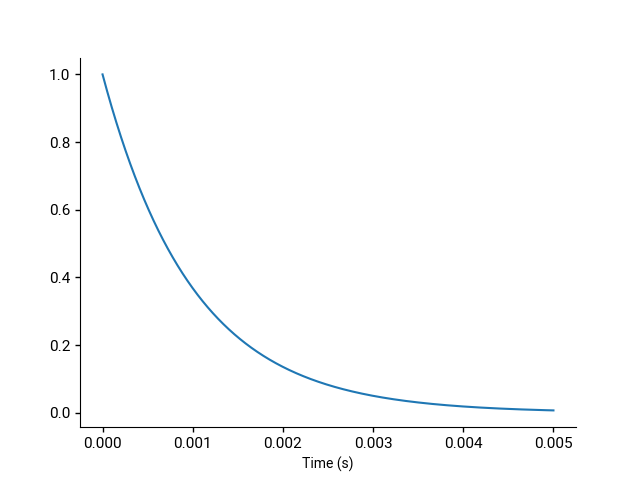

In [5]:
tau = 1 / hz / 10
v0 = 1

cycle_dur = 1 / hz
half_cycle_dur = cycle_dur / 2
half_cycle_pts = int(n_pts / (dur * hz) / 2)
half_cycle = np.linspace(0, half_cycle_dur, half_cycle_pts)
half_cycle_decay = np.array([v0 * np.exp(-t / tau) for t in half_cycle])

decay_fig, decay_ax = plt.subplots(1)
decay_ax.plot(half_cycle, half_cycle_decay)
decay_ax.set_xlabel("Time (s)")
clean_axes(decay_ax)

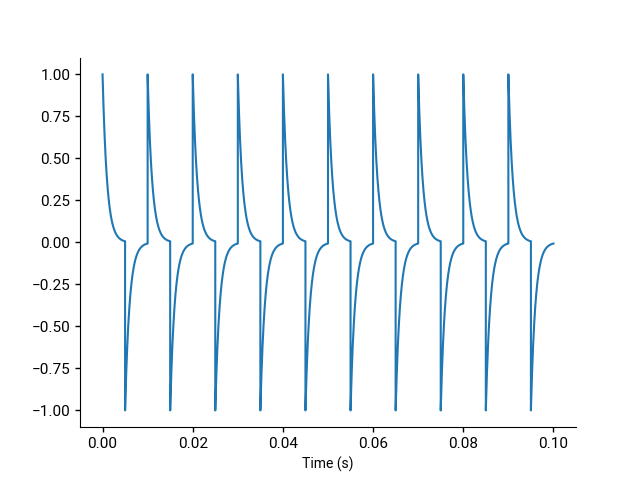

In [6]:
cycle_pts = half_cycle_pts * 2
cycle_decay = np.concatenate([half_cycle_decay, -1 * half_cycle_decay])
transients = np.tile(cycle_decay, int(dur * hz))

transients_fig, transients_ax = plt.subplots(1)
transients_ax.plot(xaxis, transients)
transients_ax.set_xlabel("Time (s)")
clean_axes(transients_ax)

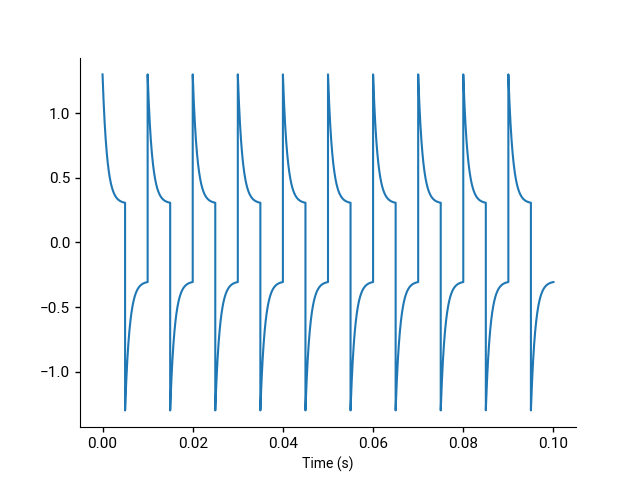

In [7]:
sq_scale = 0.3
full_steps = sq * sq_scale + transients
full_steps_fig, full_steps_ax = plt.subplots(1)
full_steps_ax.plot(xaxis, full_steps)
full_steps_ax.set_xlabel("Time (s)")
clean_axes(full_steps_ax)

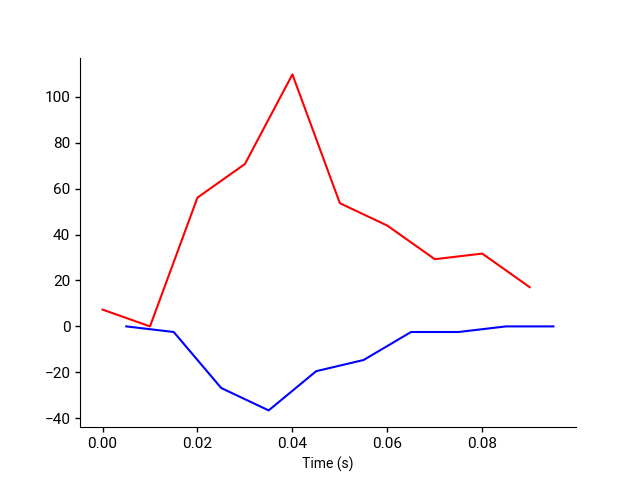

In [8]:
data_path = "/home/geoff/git/notes/balance_paper/new_figs/oscillating_clamp/"
inh_path = os.path.join(data_path, "cafaro_oscillating_inh.csv")
exc_path = os.path.join(data_path, "cafaro_oscillating_exc.csv")

inh = np.loadtxt(inh_path, delimiter=",")[:, 1]
inh -= np.min(inh)
exc = np.loadtxt(exc_path, delimiter=",")[:, 1]
exc -= np.max(exc)
trace_ax = np.arange(len(inh)) / hz

ei_traces_fig, ei_traces_ax = plt.subplots(1)
ei_traces_ax.plot(trace_ax, inh, c="red")
ei_traces_ax.plot(trace_ax + half_cycle_dur, exc, c="blue")
ei_traces_ax.set_xlabel("Time (s)")
clean_axes(ei_traces_ax)

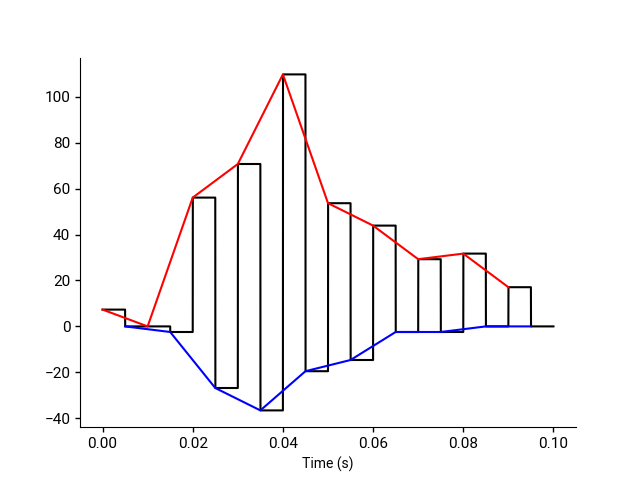

In [9]:
split_inh = np.zeros_like(xaxis)
split_exc = np.zeros_like(xaxis)
for i in range(len(inh)):
    c0 = cycle_pts * i
    split_inh[c0:c0 + half_cycle_pts] = inh[i]
    split_exc[c0 + half_cycle_pts:c0 + cycle_pts] = exc[i]

split_traces = split_inh + split_exc
    
split_trace_fig, split_trace_ax = plt.subplots(1)
split_trace_ax.plot(xaxis, split_traces, c="black")
split_trace_ax.plot(trace_ax, inh, c="red")
split_trace_ax.plot(trace_ax + half_cycle_dur, exc, c="blue")
split_trace_ax.set_xlabel("Time (s)")
clean_axes(split_trace_ax)

In [10]:
step_scale = 100
current = full_steps * step_scale + split_traces

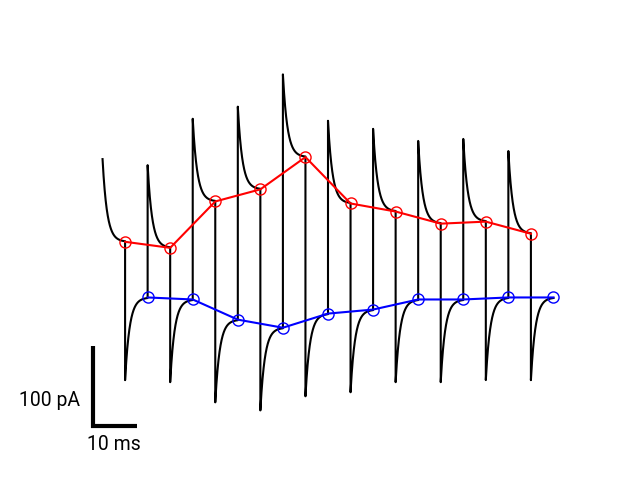

In [11]:
current_fig, current_ax = plt.subplots(1)
current_ax.plot(xaxis, current, c="black")
marks = dict(marker="o", mfc="none", markersize=8)
current_ax.plot(trace_ax + half_cycle_dur, inh + sq_scale * step_scale, c="red", **marks)
current_ax.plot(trace_ax + cycle_dur, exc - sq_scale * step_scale, c="blue", **marks)
current_ax.set_xlabel("Time (s)")
clean_axes(current_ax)

sizex = 0.01
sizey = 100
add_scalebar(
    current_ax,
    matchx=False, 
    matchy=False, 
    sizex=sizex, 
    sizey=sizey, 
    labelx="%i ms" % (sizex * 1000),
    labely="%i pA" % sizey,
    sep=5,
    barwidth=3,
    loc="center",
    bbox_to_anchor=(80, 80),
    textprops={"fontsize": 14},
)

for ext in exts:
    name = os.path.join(fig_path, "cafaro_current_schematic_recreation%s" % (ext))
    current_fig.savefig(name, bbox_inches="tight")

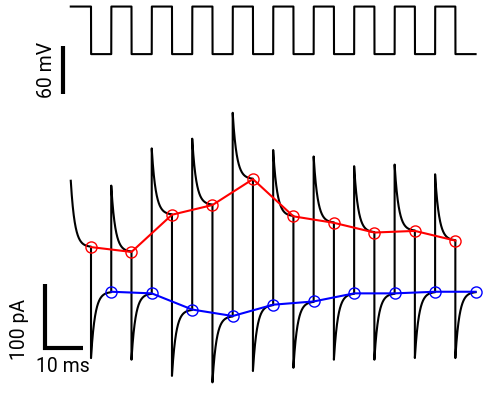

In [12]:
sq_mv = signal.square(2 * np.pi * hz * xaxis) * 30 - 30

steps_and_current_fig, steps_and_current_ax = plt.subplots(
    2, gridspec_kw={"height_ratios": [0.15, 0.85]}, figsize=(5, 4))

steps_and_current_ax[0].plot(xaxis, sq_mv, c="black")

steps_and_current_ax[1].plot(xaxis, current, c="black")
marks = dict(marker="o", mfc="none", markersize=8)
steps_and_current_ax[1].plot(trace_ax + half_cycle_dur, inh + sq_scale * step_scale, c="red", **marks)
steps_and_current_ax[1].plot(trace_ax + cycle_dur, exc - sq_scale * step_scale, c="blue", **marks)
steps_and_current_ax[1].set_xlabel("Time (s)")

clean_axes(steps_and_current_ax, remove_spines=["top", "left", "right", "bottom"])

mv_scale = True
sizey = 60

if mv_scale:
    add_scalebar(
        steps_and_current_ax[0],
        matchx=False, 
        matchy=False, 
        sizey=sizey, 
        labely="%i mV" % sizey,
        sep=5,
        barwidth=3,
        loc="center",
        bbox_to_anchor=(50, 330),
        textprops={"fontsize": 14},
        ytextprops={"rotation": "vertical"},
    )

sizex = 0.01
sizey = 100
add_scalebar(
    steps_and_current_ax[1],
    matchx=False, 
    matchy=False, 
    sizex=sizex, 
    sizey=sizey, 
    labelx="%i ms" % (sizex * 1000),
    labely="%i pA" % sizey,
    sep=5,
    barwidth=3,
    loc="center",
    bbox_to_anchor=(50, 70),
    textprops={"fontsize": 14},
    ytextprops={"rotation": "vertical"},
)

steps_and_current_fig.set_layout_engine("compressed")

for ext in exts:
    name = os.path.join(fig_path, "cafaro_steps_and_current_schematic_recreation%s" % (ext))
    steps_and_current_fig.savefig(name, bbox_inches="tight")